In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [32]:
class GaussianMixtureModel:
    def __init__(self, n_components=2, max_iterations=100, tolerance=1e-8):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = None
        self.means = None
        self.covariances = None
        self.log_lval = None
        self.responsibilities = None

    def apply_pca(self, data, components):
        X = data
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean) / std
        X_norm = np.array(X_norm)
        # return X_norm
        # print(X_norm.shape)
        cov_matrix = np.cov(X_norm.T)
        eigvals, eigvecs = np.linalg.eig(cov_matrix)
        eigpairs = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]
        eigpairs.sort(reverse=True, key=lambda x: x[0])
        sortvecs = np.array([pair[1] for pair in eigpairs[:components]])
        reduced_data = np.dot(X_norm, sortvecs.T)
        return reduced_data

    def fit(self, data):
        num_samples, num_features = data.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = data[np.random.choice(num_samples, self.n_components, replace=False)]
        # self.covariances = [np.cov(data, rowvar=False)] * self.n_components
        self.covariances = [np.eye(len(data[0])) for _ in range(self.n_components)]
        
        # EM algorithm
        iteration = 0
        globe_val = 0
        while True:
            responsibilities = self._calculate_responsibilities(data)

            self._update_parameters(data, responsibilities)

            log_likelihood = self._calculate_log_likelihood(data)
            globe_val = log_likelihood
            # print(f"Iteration {iteration+1}, Log-Likelihood: {log_likelihood}")
            if iteration > 0 and abs(log_likelihood - prev_log_likelihood) < self.tolerance:
                break
            iteration += 1
            prev_log_likelihood = log_likelihood
        # print(iteration)
        self.log_lval = globe_val
        # print(globe_val)

    def _calculate_responsibilities(self, data):
        responsibilities = np.zeros((data.shape[0], self.n_components))
        for c in range(self.n_components):
            likelihood = multivariate_normal.pdf(data, mean=self.means[c], cov=self.covariances[c], allow_singular=False)
            responsibilities[:, c] = (
                self.weights[c] * likelihood
            )

        normalization_factor = np.sum(responsibilities, axis=1, keepdims=True)
        responsibilities /= normalization_factor
        self.responsibilities = responsibilities
        return responsibilities

    def regularise(self, data, covar):
        small_constant = 1e-6
        return covar + small_constant * np.eye(data.shape[1])

    def _update_parameters(self, data, responsibilities):
        total_responsibilities = np.sum(responsibilities, axis=0)
        self.weights = total_responsibilities / data.shape[0]
        self.means = np.dot(responsibilities.T, data) / total_responsibilities[:, np.newaxis]
        # print(responsibilities.shape)
        for c in range(self.n_components):
            weighted_diff = responsibilities[:, c][:, np.newaxis] * (data - self.means[c])
            numerator_term = np.dot(weighted_diff.T, data - self.means[c])

            # Regularising covariance matrix for numerical stability
            numerator_term = self.regularise(data, numerator_term)

            self.covariances[c] = numerator_term / total_responsibilities[c]

            # Diagonal GMM
            self.covariances[c] = np.diag(np.diag(self.covariances[c]))

    def _multivariate_normal_pdf(self, x, mean, covariance):
        d = x.shape[1]
        det_cov = np.linalg.det(covariance)
        inv_cov = np.linalg.inv(covariance)
        exponent = np.sum(np.dot((x - mean), inv_cov) * (x - mean), axis=1)
        var = 1 / (np.sqrt((2 * np.pi) ** d * det_cov))
        var *= np.exp(-0.5 * exponent)
        return var

    def _calculate_log_likelihood(self, data):
        log_likelihoods = np.zeros(data.shape[0])
        for c in range(self.n_components):
            log_likelihoods += self.weights[c] * multivariate_normal.pdf(data, mean=self.means[c], cov=self.covariances[c], allow_singular=False)
        # print(log_likelihoods.shape)
        return np.sum(np.log(log_likelihoods))

    def get_parameters(self):
        return self.weights, self.means, self.covariances

    def calculate_likelihoods(self, data):
        likelihoods = np.zeros((data.shape[0], self.n_components))
        for c in range(self.n_components):
            likelihoods[:, c] = (
                self.weights[c] * multivariate_normal.pdf(data, mean=self.means[c], cov=self.covariances[c], allow_singular=False)
            )
        return likelihoods

    def calculate_membership_values(self, data):
        responsibilities = self._calculate_responsibilities(data)
        return responsibilities
    
    def predict_membership(self):
        return np.argmax(self.responsibilities, axis=1)


In [7]:
data = pd.read_csv("SMAI-Dataset-customer-dataset/data.csv").values  # Assuming the CSV file contains numerical data
gmm = GaussianMixtureModel(n_components=100)
data = gmm.apply_pca(data, 7)
gmm.fit(data)
weights, means, covariances = gmm.get_parameters()


sklearn_gmm = GaussianMixture(n_components=100, covariance_type='diag')
sklearn_gmm.fit(data)
sklearn_log_likelihood = sklearn_gmm.score(data)

print("My model log-likelihood: ", gmm.log_lval)
# print(f"Scikit-learn Log Likelihood: {sklearn_log_likelihood}")
sklearn_weights = sklearn_gmm.weights_
sklearn_means = sklearn_gmm.means_
sklearn_covariances = sklearn_gmm.covariances_

print("GMM Weights:", weights)
print("GMM Means:", means)
print("GMM Covariances:", covariances)
print("SKLEARN GMM Weights:", sklearn_weights)
print("SKLEARN GMM Means:", sklearn_means)
# print("SKLEARN GMM Covariances:", sklearn_covariances)
likelihoods = gmm.calculate_likelihoods(data)
membership_values = gmm.calculate_membership_values(data)

My model log-likelihood:  -6438.881434415463
GMM Weights: [0.00395645 0.00850854 0.01005914 0.00837422 0.01492476 0.00898186
 0.001      0.00610431 0.01045265 0.00349848 0.01249132 0.0213672
 0.00999084 0.01330501 0.01259741 0.00248061 0.01058578 0.02088973
 0.01357157 0.01821949 0.01848959 0.00847723 0.01740668 0.00149801
 0.01287838 0.01032699 0.01320401 0.00549384 0.01095987 0.00612858
 0.00654305 0.00543919 0.01331643 0.00749318 0.00949154 0.01476635
 0.00557126 0.01050003 0.0040001  0.009      0.01498629 0.01519021
 0.00602423 0.02010356 0.00948583 0.007      0.01159328 0.00999455
 0.01017039 0.00796596 0.0105     0.00250087 0.00649993 0.003
 0.01571962 0.01001037 0.02002218 0.01250244 0.02208369 0.00761754
 0.00527942 0.00593105 0.00745923 0.00457997 0.00550068 0.00797284
 0.00150578 0.00400829 0.002      0.00642541 0.00993857 0.0155
 0.01299044 0.02112474 0.00697142 0.01003033 0.0080649  0.00600769
 0.01997365 0.01456381 0.02038955 0.0115     0.00300075 0.00449998
 0.01166638 0.

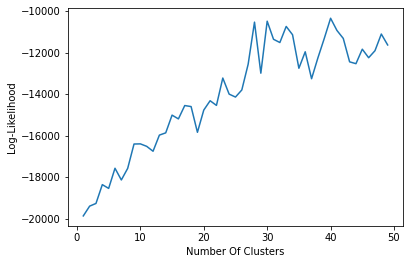

In [13]:
num_cl = []
log_likelihoods = []

for i in range(1, 50):
    gmm = GaussianMixtureModel(n_components=i)
    data = gmm.apply_pca(data, 7)
    gmm.fit(data)
    log_likelihoods.append(gmm.log_lval)
    num_cl.append(i)
    
plt.plot(num_cl, log_likelihoods)
plt.xlabel("Number Of Clusters")
plt.ylabel("Log-Likelihood")
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics

# Load the wine dataset
wine = datasets.load_wine()
wdata = wine.data
wtarget = wine.target

In [24]:
X = np.asarray(wdata)
y = np.asarray(wtarget)

aic = []
bic = []
num_clusters = []
num_features = 2

def calc_BIC(log_likelihood, num_features, k, X):
    return (k - 1 + (-2 * log_likelihood) + (k * num_features + (k * num_features*(num_features + 1)/2)) * np.log(len(X)))

def calc_AIC(log_likelihood, num_features, k, X):
    return (k - 1 + (-2 * log_likelihood) + 2 * (k * num_features + (k * num_features*(num_features + 1)/2)))

for k in range(1,21):
    num_clusters.append(k)
    gmm = GaussianMixtureModel(n_components = k)
    X = gmm.apply_pca(X, 2)
    gmm.fit(X)
    weights, means, covariances = gmm.get_parameters()
    log_likelihood = gmm.log_lval
    bic_value = calc_BIC(log_likelihood, num_features, k, X)
    aic_value = calc_AIC(log_likelihood, num_features, k, X)
    bic.append(bic_value)
    aic.append(aic_value)

<h2> Observations </h2>
The silhouette score measures how close each data point in one cluster is to the data points in the neighboring clusters. A higher silhouette score indicates that the clusters are well-separated. For the K means clustering silhouette score is maximised at clusters and we can see from the cluster graphs that 3 clusters fit the graphs well. The similar trend is observed for the GMM scores. The score predicts the optimal clusters to be  around 3-4 which is correct. Both the K-Means and Gaussian Mixture Model (GMM) clustering methods suggest the optimal number of clusters as the same, which is three. This consensus indicates that the underlying structure of the data is best represented by three distinct clusters in the reduced 2-dimensional feature space obtained through Principal Component Analysis (PCA).

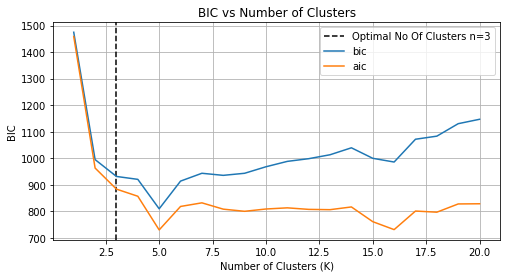

In [25]:
# GPT prompt for plotting optimal line at k = 3 and AIC/BIC score.
plt.figure(figsize=(8, 4))
plt.axvline(x = 3, color = 'black', linestyle='--', label = 'Optimal No Of Clusters n=3')
plt.plot(num_clusters, bic, linestyle='-', label='bic')
plt.plot(num_clusters, aic, linestyle='-', label='aic')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC')
plt.title('BIC vs Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
num_clusters = 3
mean_val = np.mean(X, axis = 0)
std_val = np.std(X, axis = 0)
X = (X - mean_val)/ std_val

# GPT Prompt to apply Kmeans clustering on wine dataset.
kmeans = KMeans(n_clusters = num_clusters, n_init = 10)
pca_X = PCA(n_components=2) 
reduced_data_X = pca_X.fit_transform(X)

kmeans.fit(reduced_data_X)
centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

x_data = reduced_data_X[:, 0]  
y_data = reduced_data_X[:, 1]  

x_cluster = centers[:, 0]
y_cluster = centers[:, 1]

print("The Cluster Means are:")
print()
print(centers)

The Cluster Means are:

[[-0.72223696 -0.82862866]
 [-0.35934245  1.16327569]
 [ 1.44963272 -0.29822589]]


Silhouette score is 0.4409102148670759 for num_clusts = 2
Silhouette score is 0.5795318146437427 for num_clusts = 3
Silhouette score is 0.4841876608634497 for num_clusts = 4
Silhouette score is 0.44837800668417993 for num_clusts = 5
Silhouette score is 0.46470144402318114 for num_clusts = 6
Silhouette score is 0.4475661922471427 for num_clusts = 7
Silhouette score is 0.4280523555439633 for num_clusts = 8
Silhouette score is 0.40238462863890184 for num_clusts = 9
Silhouette score is 0.40923635153771154 for num_clusts = 10


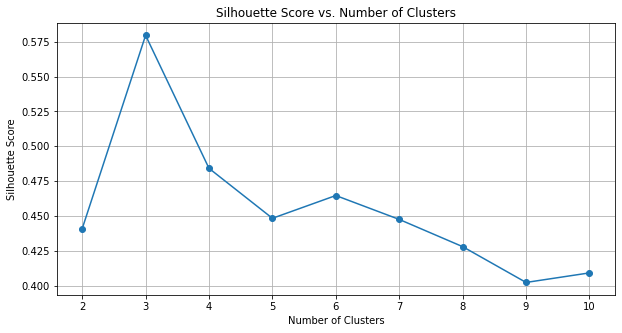

The optimal number of clusters is 3


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Chatgpt prompt to plot the silhoutte score for each num_clusts

# Define the range of cluster numbers to consider
minum_clusts = 2
max_clusters = 10

# Initialize a list to store silhouette scores
silhouette_scores = []

# Loop through different cluster numbers and compute silhouette scores
for num_clusts in range(minum_clusts, max_clusters + 1):
    # Create a KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusts, n_init=10)
    
    # Fit the model and predict cluster labels
    cluster_labels = kmeans.fit_predict(reduced_data_X)
    
    # Compute the silhouette score for the current clustering
    silhouette_avg = silhouette_score(reduced_data_X, cluster_labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)
    
    # Print the silhouette score for the current number of clusters
    print(f"Silhouette score is {silhouette_avg} for num_clusts = {num_clusts}")

# Find the optimal number of clusters with the highest silhouette score
optimal_clusters = np.argmax(silhouette_scores) + minum_clusts

# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(minum_clusts, max_clusters + 1), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xticks(range(minum_clusts, max_clusters + 1))
plt.grid(True)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is {optimal_clusters}")

Silhouette score is 0.43522488656799563 for num_clusts = 2
Silhouette score is 0.5759778123728617 for num_clusts = 3
Silhouette score is 0.518102188716606 for num_clusts = 4
Silhouette score is 0.3939229702053353 for num_clusts = 5
Silhouette score is 0.34253379547008844 for num_clusts = 6
Silhouette score is 0.3381999562353666 for num_clusts = 7
Silhouette score is 0.3874611334967947 for num_clusts = 8
Silhouette score is 0.38475751117842366 for num_clusts = 9
Silhouette score is 0.31260762663735703 for num_clusts = 10
Silhouette score is 0.3197253182772787 for num_clusts = 11
Silhouette score is 0.27596806613649044 for num_clusts = 12
Silhouette score is 0.26075174884986146 for num_clusts = 13
Silhouette score is 0.28652685759702 for num_clusts = 14
Silhouette score is 0.27832294474487373 for num_clusts = 15


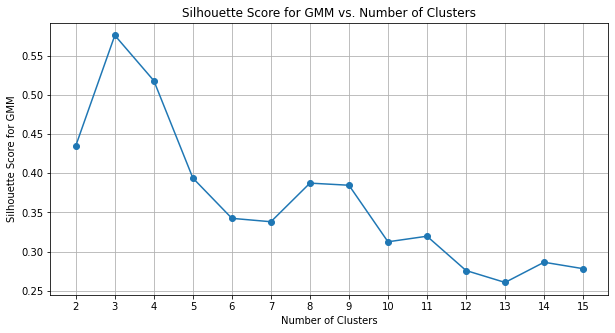

The optimal number of clusters with GMM is 3


In [38]:
# ChatGPT Prompt to calculate silhouette score for GMM clustering and then find optimal number of clusters using the constructed class
# according to my entire GMM class.
minum_clusts = 2
max_clusters = 15
silhouette_scores = []

for num_clusts in range(minum_clusts, max_clusters + 1):
    gmm = GaussianMixtureModel(n_components = num_clusts)
    gmm.fit(gmm.apply_pca(X, 3))
    silhouette_scores.append(silhouette_score(X, gmm.predict_membership()))
    print(f"Silhouette score is {silhouette_score(X, gmm.predict_membership())} for num_clusts = {num_clusts}")

optimal_clusters = minum_clusts + np.argmax(silhouette_scores)

plt.figure(figsize=(10, 5))
plt.plot(range(minum_clusts, max_clusters + 1), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score for GMM")
plt.title("Silhouette Score for GMM vs. Number of Clusters")
plt.xticks(range(minum_clusts, max_clusters + 1))
plt.grid(True)
plt.show()

print(f"The optimal number of clusters with GMM is {optimal_clusters}")